# Amplitude embedding (hardware)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[ 0.00699048+2.9690408e-03j -0.10527938+6.9923764e-03j
  -0.02412227+2.2223801e-03j  0.06518189+1.5795002e-02j]
 [ 0.10005059+2.1744996e-02j  0.05574617+7.0536188e-03j
   1.3773637 +5.2812672e+00j  0.19915766-1.9269134e-03j]
 [-0.091119  +2.8694016e-03j  1.3773637 +5.2812672e+00j
   1.3773637 +5.2812672e+00j  1.3773637 +5.2812672e+00j]
 [ 0.08688591+1.7097402e-02j -0.1231077 +1.7406490e-02j
   1.3773637 +5.2812672e+00j  0.0880686 -1.9809514e-02j]]


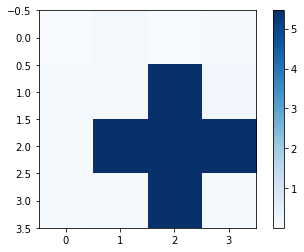

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 7.1452713+26.47875j   -3.967767 -15.276294j   1.2762822 +5.3026595j
  -4.042555 -16.326391j ]
 [-4.086024 -16.1218j     1.4276756 +5.4646764j  1.4885663 +5.53758j
   1.5808104 +5.067283j ]
 [ 0.8222142 +5.2705493j  1.0754218 +5.0619144j -4.167316 -15.894647j
   1.18542   +5.430167j ]
 [-4.1103787-15.515585j   1.55391   +5.434535j   1.4943305 +4.9840236j
   1.4359857 +5.1500835j]]


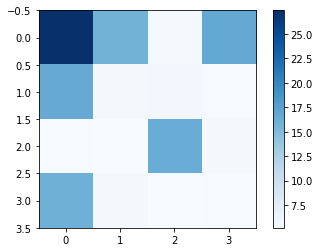

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 2.8174213e-15
Imaginaries MSE: 2.5540856e-15


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [8]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qbits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires, shots=1) # hardware (MOTIVATION?)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.expval(qml.PauliZ(0)) #, qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

ValueError: probabilities do not sum to 1

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')